## Requirements env + moduls

In [4]:
import pytesseract as tess
from PIL import Image
from glob import glob
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.utils import img_to_array, load_img, to_categorical
from PIL import Image, ImageDraw
import cv2 as cv


import subprocess
from IPython.display import FileLink, display

In [5]:


img_size = (224, 224, 3) 
img = sorted(glob(r'/kaggle/input/birdies/images/*'))
label = sorted(glob(r'/kaggle/input/birdies/labels/*'))
images = img[:3]
label = label[:3]



## Download the dataset

In [6]:

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

## Drawing gradient background

In [7]:
class Point(object):
    def __init__(self, x, y):
        self.x, self.y = x, y

class Rect(object):
    def __init__(self, x1, y1, x2, y2):
        minx, maxx = (x1,x2) if x1 < x2 else (x2,x1)
        miny, maxy = (y1,y2) if y1 < y2 else (y2,y1)
        self.min = Point(minx, miny)
        self.max = Point(maxx, maxy)

    width  = property(lambda self: self.max.x - self.min.x)
    height = property(lambda self: self.max.y - self.min.y)

#class Gradient()

In [8]:


BLACK, DARKGRAY, GRAY = ((0,0,0), (63,63,63), (127,127,127))
LIGHTGRAY, WHITE = ((191,191,191), (255,255,255))
BLUE, GREEN, RED = ((0, 0, 255), (0, 255, 0), (255, 0, 0))
YELLOW = (255, 255, 0)

class Point(object):
    def __init__(self, x, y):
        self.x, self.y = x, y

class Rect(object):
    def __init__(self, x1, y1, x2, y2):
        minx, maxx = (x1,x2) if x1 < x2 else (x2,x1)
        miny, maxy = (y1,y2) if y1 < y2 else (y2,y1)
        self.min = Point(minx, miny)
        self.max = Point(maxx, maxy)

    width  = property(lambda self: self.max.x - self.min.x)
    height = property(lambda self: self.max.y - self.min.y)


def gradient_color(minval, maxval, val, color_palette):
    """ Computes intermediate RGB color of a value in the range of minval
        to maxval (inclusive) based on a color_palette representing the range.
    """
    max_index = len(color_palette)-1
    delta = maxval - minval
    if delta == 0:
        delta = 1
    v = float(val-minval) / delta * max_index
    i1, i2 = int(v), min(int(v)+1, max_index)
    (r1, g1, b1), (r2, g2, b2) = color_palette[i1], color_palette[i2]
    f = v - i1
    return int(r1 + f*(r2-r1)), int(g1 + f*(g2-g1)), int(b1 + f*(b2-b1))

def horz_gradient(draw, rect, color_func, color_palette):
    minval, maxval = 1, len(color_palette)
    delta = maxval - minval
    width = float(rect.width)  # Cache.
    for x in range(rect.min.x, rect.max.x+1):
        f = (x - rect.min.x) / width
        val = minval + f * delta
        color = color_func(minval, maxval, val, color_palette)
        draw.line([(x, rect.min.y), (x, rect.max.y)], fill=color)

def vert_gradient(draw, rect, color_func, color_palette):
    minval, maxval = 1, len(color_palette)
    delta = maxval - minval
    height = float(rect.height)  # Cache.
    for y in range(rect.min.y, rect.max.y+1):
        f = (y - rect.min.y) / height
        val = minval + f * delta
        color = color_func(minval, maxval, val, color_palette)
        draw.line([(rect.min.x, y), (rect.max.x, y)], fill=color)




## Make frame for transfer original img on gradient BG and make bоx recalculation

<ipython-input-8-06963983c212>:33: RuntimeWarning: overflow encountered in scalar subtract
  return int(r1 + f*(r2-r1)), int(g1 + f*(g2-g1)), int(b1 + f*(b2-b1))


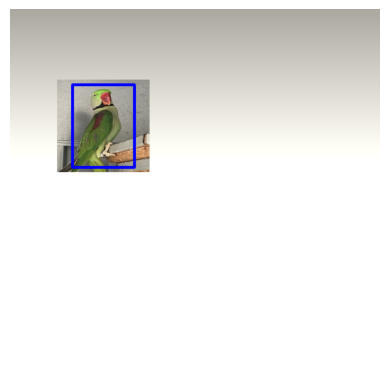

In [9]:
colour_dict = {'BLACK':(0,0,0),
               'DARKGRAY':(63,63,63),
               'GRAY': (127,127,127),
               'LIGHTGRAY':(191,191,191),
               'WHITE': (255,255,255),
               'BLUE': (0, 0, 255),
               'GREEN': (0, 255, 0),
               'RED': (255, 0, 0),
               'YELLOW': (255, 255, 0)
              }

def ShowImage(BG, xmin, ymin, xmax, ymax):
    plt.axis('off')
    #plt.figure(figsize=(5,5))
    cv.rectangle(BG, (xmin, ymin), (xmax, ymax), (0,0,255), 6) # drow box
    plt.imshow(BG);
    plt.show();


class BOX():

    def __init__(self, scale_w, scale_h, image_size, img, label, grad=False, colour_dict=None, grad_from_img=False):
        self.scale_w = scale_w
        self.scale_h = scale_h
        self.image_size = image_size
        self.img = img
        self.label = label
        self.grad = grad
        self.colour_dict = colour_dict
        self.grad_from_img = grad_from_img
        self.BG, self.coordinates  = self.box_generator()


    def get_box(self): 
    # 
        with open(self.label) as f: # read the lables
            line=f.readline()    
        box_params = line.split() # split the labels
        xc = np.float16(box_params[1])  # center x
        yc = np.float16(box_params[2])    # center y
        
        bw = np.float16(box_params[3])  # width
        bh = np.float16(box_params[4])  # height 
        return xc, yc, bw, bh
    
    def box_generator(self):
        coordinates = [0]
        IMG = Image.open(self.img)
        IMG = IMG.resize((self.image_size[0],self.image_size[1]))
        IMG = np.asarray(IMG)
        if self.grad == False:
            BG = np.random.randint(low=0,high=256,size=self.image_size[0]*self.scale_w*self.image_size[1]*self.scale_h*self.image_size[2], dtype=np.uint16)
            BG = BG.reshape(self.image_size[0]*self.scale_w, self.image_size[1]*self.scale_h,self.image_size[2])
        else:
            if self.grad_from_img == True:
                first = IMG[5][5]
                second = IMG[-5][5]
                palette = [first, second]
            else:
                first = np.random.choice(list(self.colour_dict.keys()))
                second =  np.random.choice(list(self.colour_dict.keys()))
                palette = [self.colour_dict[first], self.colour_dict[second]]
            region = Rect(0,0, self.image_size[0]*self.scale_w, self.image_size[1]*self.scale_h)
            width, height = region.max.x+1, region.max.y+1
            width, height = self.image_size[0]*self.scale_w, self.image_size[1]*self.scale_h
            image  = Image.new("RGB", (width, height), WHITE)
            draw = ImageDraw.Draw(image)
            vert_gradient(draw, region, gradient_color, palette)
            BG = np.array(image)
          
        
        
        # choose a coordinates for place an img to BG
        y_c = np.random.choice(range(np.int32(self.image_size[0]/2+7),np.int32(BG.shape[0]-self.image_size[0]/2)-7)) ##!!!!
        x_c = np.random.choice(range(np.int32(self.image_size[1]/2+7),np.int32(BG.shape[1]-self.image_size[1]/2)-7))
        
     
        # load box coordinats for original img
        xc, yc, bw, bh = self.get_box()
        x_min_img, x_max_img, y_min_img, y_max_img = x_c-int(self.image_size[0]/2), x_c+int(self.image_size[0]/2), y_c-int(self.image_size[1]/2), y_c+int(self.image_size[1]/2)
        # recalculate coordinates for box
        xc, yc, bw, bh = ((x_min_img+x_max_img)/2+xc)/(self.image_size[0]*self.scale_w), ((y_min_img+y_max_img)/2+yc)/(self.image_size[1]*self.scale_h), bw/self.scale_w, bh/self.scale_h

        BG[y_min_img:y_max_img, x_min_img:x_max_img, :] = IMG
 
        coordinates.append(xc)
        coordinates.append(yc)
        coordinates.append(bw)
        coordinates.append(bh)
    
        return BG, coordinates

    def drow_new_box(self):
  
        xc = np.float16(self.coordinates[1])* self.image_size[1]*self.scale_w # center x
        yc = np.float16(self.coordinates[2])* self.image_size[0]*self.scale_h   # center y    
        bw = np.float16(self.coordinates[3])* self.image_size[1]*self.scale_w # width 
        bh = np.float16(self.coordinates[4])* self.image_size[0]*self.scale_h  # height 
    
       
        xmin = np.int16((xc - bw/2)) # 
        xmax = np.int16((xc + bw/2))
        ymin = np.int16((yc - bh/2)) # 
        ymax = np.int16((yc + bh/2))
        ShowImage(self.BG, xmin, ymin, xmax, ymax)
        #plt.tight_layout()
       # plt.show()

        
        

        
s = (224,224,3)
a = BOX(4,4, s, images[0], label[0], grad=True, colour_dict=colour_dict, grad_from_img=True)

a.drow_new_box()
        

In [10]:
tuple(a.BG[1][1])

(171, 168, 159)

In [11]:
a.coordinates,

([0,
  0.2526384081159319,
  0.31645965576171875,
  0.1671142578125,
  0.2242431640625],)

In [12]:
working_dir = '/kaggle/working/'
new_label = os.path.join(working_dir,'box')
new_imges = os.path.join(working_dir,'img')
if os.path.exists(new_label):
    shutil.rmtree(new_label)
if os.path.exists(new_imges):
    shutil.rmtree(new_imges)
os.makedirs(new_label, exist_ok=True)
os.makedirs(new_imges, exist_ok=True)




## Make dataset

In [13]:
for im_p, b_p in zip(img,label):
    new_data = BOX(4,4, s, im_p, b_p, grad=True, colour_dict=colour_dict)
    #new_data.coordinates
    #new_data.BG

    plt.imsave(os.path.join(new_imges, 'mod'+ im_p.split('/')[-1]), new_data.BG)
    box_name = new_label + 'mod' + b_p.split('/')[-1]
    with open(box_name, 'w') as f:
        f.writelines(f"{item}\n" for item in new_data.coordinates)

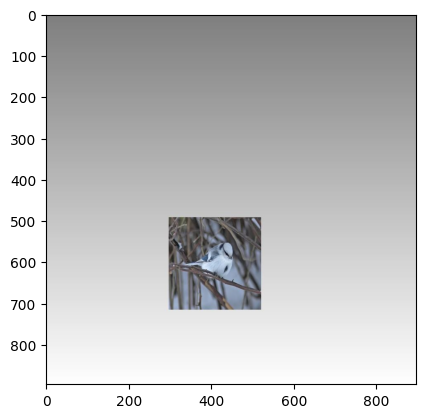

In [14]:
a = sorted(glob(new_imges+'/*'))
plt.imshow(plt.imread(a[1]));

In [ ]:
if os.path.exists(working_directory):
    shutil.rmtree(working_directory)
os.makedirs(working_directory, exist_ok=True)


for class_name in tqdm.tqdm(os.listdir(data_directory),total=len(os.listdir(data_directory))):
    class_directory = os.path.join(data_directory, class_name)
    writable_class_directory = os.path.join(working_directory, class_name)
    os.makedirs(writable_class_directory, exist_ok=True)

    for image in os.listdir(class_directory):
        src_path = os.path.join(class_directory, image)
        dest_path = os.path.join(writable_class_directory, image)
        shutil.copy(src_path, dest_path)
#for i in tqdm(range(0,len(files), total = len(files))


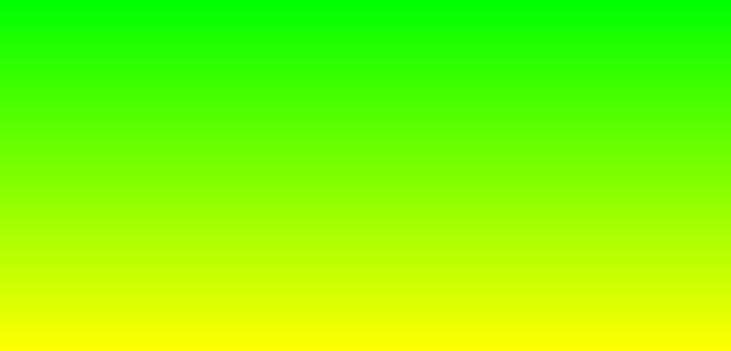

In [16]:

# Draw a three color vertical gradient.
color_palette = [GREEN, YELLOW]
region = Rect(0, 0, 730, 350)
width, height = region.max.x+1, region.max.y+1
image = Image.new("RGB", (width, height), WHITE)
draw = ImageDraw.Draw(image)
vert_gradient(draw, region, gradient_color, color_palette)
image
#image.save("vert_gradient.png", "PNG")
#print('image saved')